In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as  sns
from datetime import datetime
import numpy as np
import time
import statsmodels.api as sms # seems to the older method to do things
import statsmodels.tsa as smt # seems to be the newer way of doing things
pd.options.plotting.backend = 'matplotlib'

### predicting total sales for every product and store in the next month for Russian Software company-1c 

Competition and data overview:
In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-1c company.

What does the IC company do?:

1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.

Data: We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level. <br> 
Resources: 
1. https://yashuseth.blog/2018/01/19/time-series-analysis-forecasting-modelling-arima/
1. https://kanoki.org/2020/04/30/time-series-analysis-and-forecasting-with-arima-python/
3. https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts/notebook#AR,-MA-and-ARMA-models:
4. RitvikMaths
5. https://www.kaggle.com/prashant111/arima-model-for-time-series-forecasting

In [2]:
os.listdir('Datasets/competitive-competitive-data-science-predict-future-sales/')

['sales_train.csv',
 'shops.csv',
 'test.csv',
 'item_categories.csv',
 'items.csv',
 'sample_submission.csv',
 'monthly_temperature_aomori_city.csv']

In [3]:
sales = pd.read_csv('Datasets/competitive-competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('Datasets/competitive-competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('Datasets/competitive-competitive-data-science-predict-future-sales/test.csv')
item_cat = pd.read_csv('Datasets/competitive-competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('Datasets/competitive-competitive-data-science-predict-future-sales/items.csv', engine='python')
submit = pd.read_csv('Datasets/competitive-competitive-data-science-predict-future-sales/sample_submission.csv')

#### Sales Data

In [5]:
# 2,935,000 Records :O
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:
# date is in object format, fix it. 
sales

date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...               ...  
2935844           1.0  
2935845           1.0  
2935846           1.0  
2935847           1.0  
2935848           1.0  

[2935849 rows x 6 columns]

In [7]:
# Takes quite some time processing 2.9 millions records.
tic = time.time()
sales.date = sales.date.apply(lambda x: datetime.strptime(x , '%d.%m.%Y'))
print(f'Pre-processing step time taken {time.time() - tic} Seconds')

Pre-processing step time taken 43.161463022232056 Seconds


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [9]:
# Why not set the date as the index ? - Maybe because we need to aggregate the data monthly
# Date block num is already the month index.

# GroupBy syntax (columns to group by in list or (index by))[Columns to aggregate, apply function to].
#aggregation functions on it 

# Only groups the price as a monthly series.
monthly_sales = sales.groupby(['date_block_num'])['item_price'].mean()

In [12]:
# Lets aggregate so that we dont loose info :
# multiIndex -(date_block_num, shop_id, item_id) columns : date(min-max), item_price -mean, item_cnt_day - sum

monthly_sales = sales.groupby(['date_block_num',
                               'shop_id', 'item_id'])['date', 'item_price', 'item_cnt_day'].agg({'date' : ['min', 'max'], 'item_price' : 'mean', 'item_cnt_day' : 'sum'})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


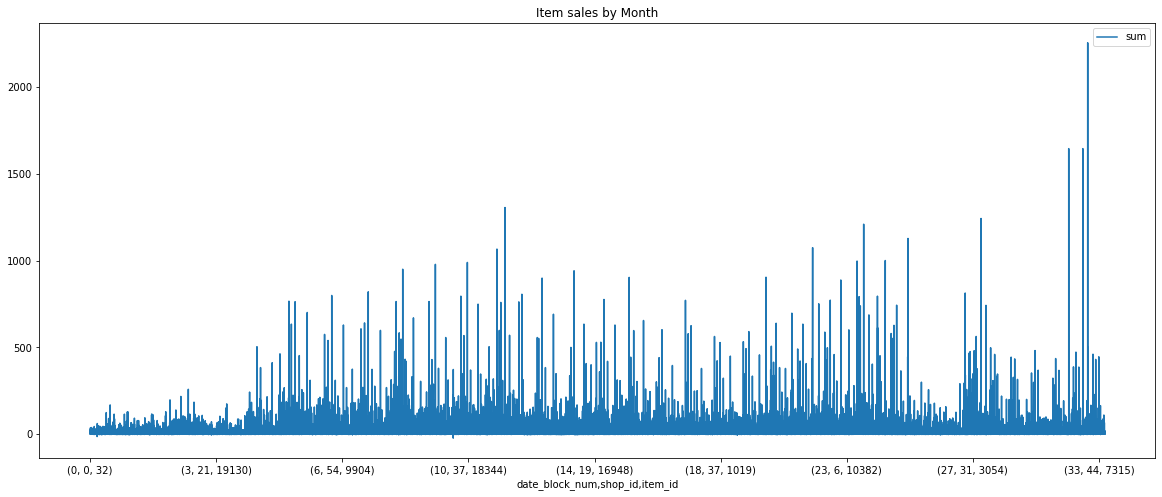

In [14]:
#plt.figure(figsize = (20,8))
monthly_sales.item_cnt_day.plot(figsize = (20,8), title = 'Item sales by Month')
plt.show()

<Figure size 1440x576 with 0 Axes>

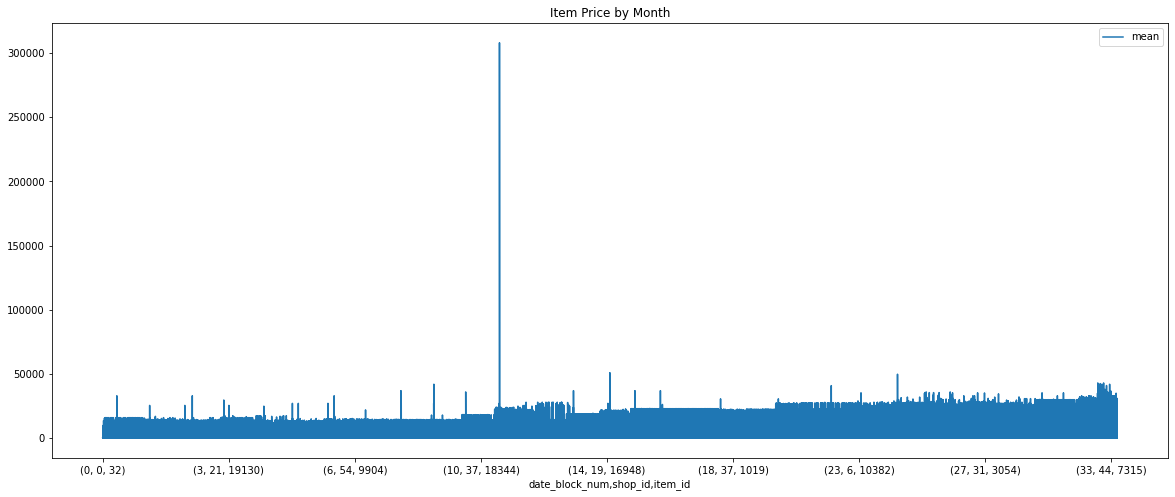

In [15]:
plt.figure(figsize = (20,8))
monthly_sales.item_price.plot(figsize = (20,8), title = 'Item Price by Month')
plt.show()

In [16]:
ts_new = sales.groupby(['date_block_num'])['item_price'].mean()

#### Item Price Time Series

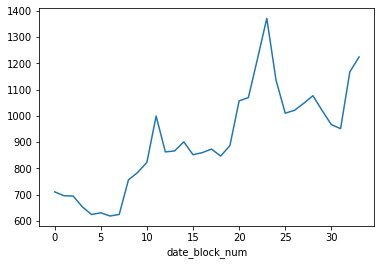

In [17]:
# Upwards trend and seasonality 
ts_new.plot()

In [20]:
perf_adf(ts_new)

Test- Stat            -1.051306
P-Value                0.734095
# of Lags Used        10.000000
# of Obs Used         23.000000
Critical Value 1%     -3.752928
Critical Value 5%     -2.998500
Critical Value 10%    -2.638967
dtype: float64

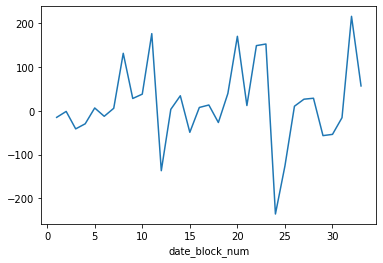

In [21]:
# Differencing by 1 to remove trend.
ts_new.diff(1).plot()

In [22]:
no_trend_ts = ts_new.diff(1)
# Performing augmented dickey fuller test.
perf_adf(no_trend_ts.dropna()) 
# Says the series is stationary but visible its got seasonality - Magnitude matters too I think.

Test- Stat            -3.323524
P-Value                0.013859
# of Lags Used         9.000000
# of Obs Used         23.000000
Critical Value 1%     -3.752928
Critical Value 5%     -2.998500
Critical Value 10%    -2.638967
dtype: float64

In [25]:
#res = sms.tsa.seasonal_decompose(no_trend_ts.dropna().values, model='multiplicative', period=12)
#res.plot()

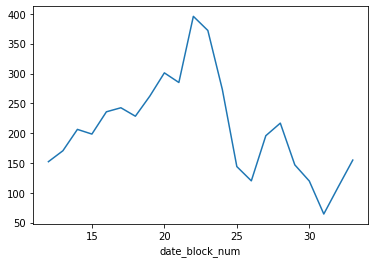

In [23]:
# Differencing by 12 to remove yearly seasonality
no_seas = ts_new.diff(12).plot()

In [24]:
# Not stationary
no_seas = ts_new.diff(12)
perf_adf(no_seas.dropna()) 

Test- Stat            -2.062651
P-Value                0.259795
# of Lags Used         9.000000
# of Obs Used         12.000000
Critical Value 1%     -4.137829
Critical Value 5%     -3.154972
Critical Value 10%    -2.714477
dtype: float64

[]

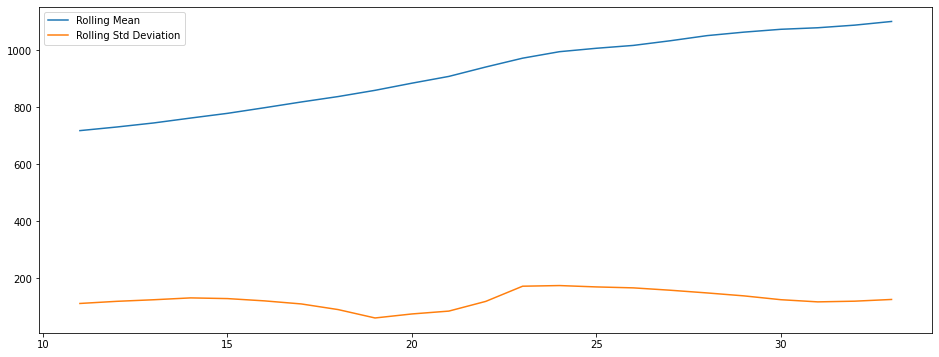

In [25]:
plt.figure(figsize=(16,6))
plt.plot(ts_new.rolling(window=12).mean(),label='Rolling Mean')
plt.plot(ts_new.rolling(window=12).std(),label='Rolling Std Deviation')
plt.legend()
plt.plot()

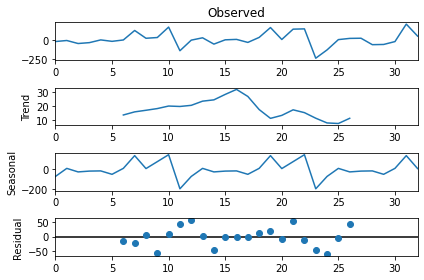

In [26]:
# decompose using statsmodels api and seasonal decompose function
import statsmodels.api as sms

# With differenced time series, it looks seasonal to me but the method thinks otherwise
res = sms.tsa.seasonal_decompose(ts_new.diff(1).dropna().values, model='additive', period=12)

# can the use the result to directly plot the graphs

seas_decomp = res.plot()

In [27]:
# decompose using statsmodels api and seasonal decompose function
import statsmodels.api as sms

res = sms.tsa.seasonal_decompose(ts_new.values, model='multiplicative', period=12)

# can the use the result to directly plot the graphs

res.plot()

### Item File

In [28]:
items

item_name  item_id  \
0              ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      !ABBYY FineReader 12 Professional Edition Full...        1   
2          ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3        ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4            ***КОРОБКА (СТЕКЛО)                       D        4   
...                                                  ...      ...   
22165             Ядерный титбит 2 [PC, Цифровая версия]    22165   
22166    Язык запросов 1С:Предприятия  [Цифровая версия]    22166   
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id  
0                    40  
1                    76  
2                    40  
3                    40  
4                    40  
...                 ...  
22165                31  
22166                54  
22167                49  
22168                62  
22169                69  

[22170 rows x 3 columns]

In [29]:
# how many items per category ID

x = items.groupby(['item_category_id']).count()

In [30]:
x.sort_values(by = 'item_id', ascending=False, inplace=True)

In [31]:
# Resetting index keeps a copy of the existing index as a col by default.
x=x.iloc[0:10].reset_index()
x

item_category_id  item_name  item_id
0                40       5035     5035
1                55       2365     2365
2                37       1780     1780
3                31       1125     1125
4                58        790      790
5                30        756      756
6                72        666      666
7                19        628      628
8                61        598      598
9                23        501      501

In [32]:
plt.figure(figsize = (8,6))
plt.xlabel('Category ID')
plt.ylabel('Number of items')
sns.barplot(x = 'item_category_id', y = 'item_name', data=x)
plt.title('Items per category')
plt.show()

### Time- Series
There are basically two time series' - Item sales by Month and Item price by Month.

The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

In [51]:
# Times series for sales by month.

ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()

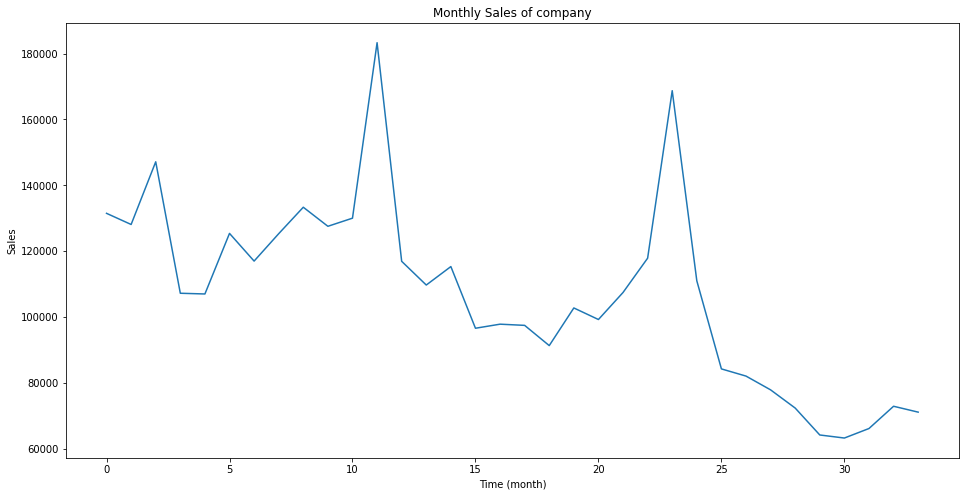

In [52]:
plt.figure(figsize=(16,8))
plt.xlabel('Time (month)')
plt.ylabel('Sales')
plt.plot(ts)
plt.title('Monthly Sales of company')
plt.show()

There is yearly seasonality and downwards trend.

#### Check Rolling Mean and Stdev
Get a 12 Month Rolling Window, will get rid of the first 11 readings. Calculates the Rolling window and then Aggregate function for that window like mean.

In [57]:
ts.rolling(window=12).mean().iloc[-5:]

date_block_num
29    98220.833333
30    95879.750000
31    92826.250000
32    90629.166667
33    87598.666667
Name: item_cnt_day, dtype: float64

[]

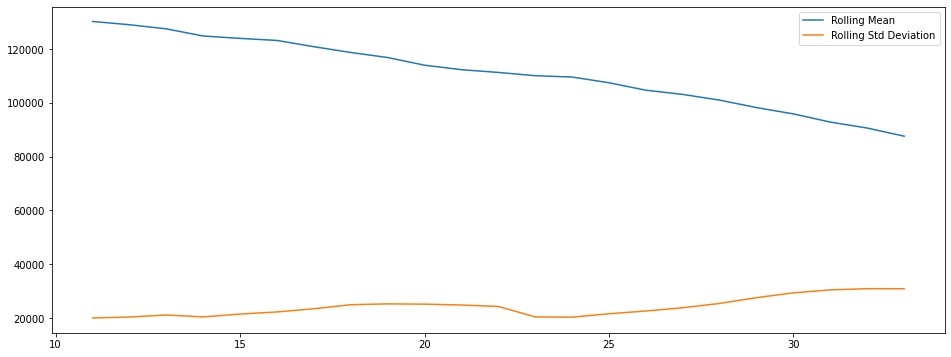

In [54]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12).mean(),label='Rolling Mean')
plt.plot(ts.rolling(window=12).std(),label='Rolling Std Deviation')
plt.legend()
plt.plot()

### Time Series Components
1. There is a downwards trend.
2. There is seasonality.<br>
<b>
The Series is not stationary. </b> - Methods of checking:
1. Plotting the Rolling Mean and STD Dev
2. Time-series seasonal decomposition - Using both the methods(additive and multiplicaitve) we see the strong downwards trend and the seasonal component(similar for both). The residuals are different both the models.
3. Augmented Dickey Fuller Test 

### Analysis

##### Seasonal decomposition using Moving Averages - Additive model
where the series is assumed to be a sum of the components: <br>
y(t) = Level + Trend + seasonality + Noise <br>
The additive model is useful when the seasonal variation is relatively constant over time.

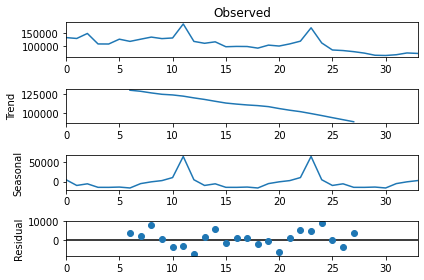

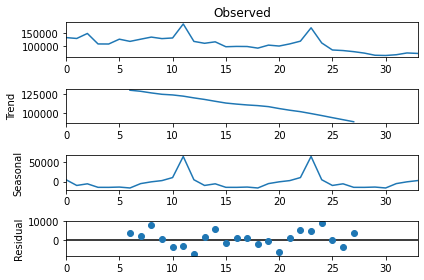

In [56]:
# decompose using statsmodels api and seasonal decompose function
import statsmodels.api as sms

res = sms.tsa.seasonal_decompose(ts.values, model='additive', period=12)

# can the use the result to directly plot the graphs

res.plot()

##### Seasonal decomposition using Moving Averages - Multiplicative model
where the series is assumed to be a product of the components: <br>
y(t) = Level * Trend * seasonality * Noise <br>
ValueError: Multiplicative seasonality is not appropriate for zero and negative values<br>
The multiplicative model is useful when the seasonal variation increases over time.

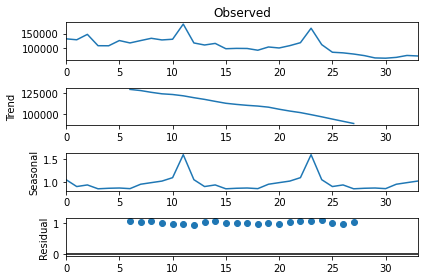

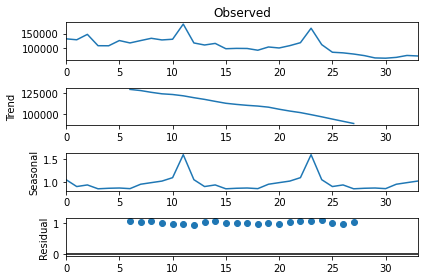

In [58]:
res = sms.tsa.seasonal_decompose(ts.values, model='multiplicative', period=12)
res.plot()

### ADF( Augmented Dicky Fuller Test)
Is a statistical Test that performs a hypothesis test for the presence of a unit root in the time series, a unit root is a characteristic of a time series that makes it non-stationary.<br>
A Dickey-Fuller test is a unit root test that tests the null hypothesis that α=1 in the following model equation. alpha is the coefficient of the first lag on Y. <br> The augmented Dickey Fuller test augments this to include high order regressive process in the model. <br>
The null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.
![](https://www.machinelearningplus.com/wp-content/uploads/2019/11/equation_1.png)
Null Hypothesis (H0): alpha=1
Good Reference : https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/ <br>
Seems to be biased towards no trend, gives significant p value even when seasonality is visible but if trend is gone. 

#### Model Evaluation - Akaike information criterion (AIC)
it is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data.
Suppose that we have a statistical model of some data. Let k be the number of estimated parameters in the model. Let 
L^be the maximum value of the likelihood function for the model. Then the AIC value of the model is the following.
AIC=2k−2ln(L^)<br>
Given a set of candidate models for the data, the preferred model is the one with the minimum AIC value. Thus, AIC rewards goodness of fit (as assessed by the likelihood function), but it also includes a penalty that is an increasing function of the number of estimated parameters.
##### Bayesian information criterion (BIC)
is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. It is based, in part, on the likelihood function and it is closely related to the Akaike information criterion (AIC).

In [59]:
from IPython.display import display

In [60]:
# Performing ADF Test
# TAakes in the time series, maxlag included in the test and autolag : Method to use when
# automatically determining the lag.

# RETURNS : 1. adf - The test statistic., 2. pvalue for hypothesis test, 3. usedlag, 4. nobs, 
# 5. critical values Critical values for the test statistic at the 1 %, 5 %, and 10 %, 6. icbest - The maximized 
# information criterion if autolag is not None.


def perf_adf(ts):
    """Performs ADF test on time series and prints Results.
    """
    dftest = sms.tsa.adfuller(ts, maxlag=None, autolag='AIC')
    df_result = pd.Series(dftest[:4], index = ['Test- Stat', 'P-Value', '# of Lags Used', '# of Obs Used'])
    # For Critical values at diff. confidence intervals
    for key, value in dftest[4].items():
        df_result[f'Critical Value {key}'] = value
    display(df_result.head(10))

In [61]:
perf_adf(ts)

Test- Stat            -2.395704
P-Value                0.142953
# of Lags Used         0.000000
# of Obs Used         33.000000
Critical Value 1%     -3.646135
Critical Value 5%     -2.954127
Critical Value 10%    -2.615968
dtype: float64

so t stat doesn't fall into the critical region and the t-stat is also not less than 0.05.
So, Time-Series is not stationary.

### Differencing to remove trend, seasonality. 
Can often make non stationary time series' Stationary.
To select the interval, the rough period in which seasonality occurs is a good bet.<br>
difference(t) = observation(t) - observation(t-1)<br>
<b>Lag Difference</b><br>
Taking the difference between consecutive observations is called a lag-1 difference.
The lag difference can be adjusted to suit the specific temporal structure.
For time series with a seasonal component, the lag may be expected to be the period (width) of the seasonality.<br>
<b>Difference Order</b>
Temporal structure may still exist after performing a differencing operation, such as in the case of a nonlinear trend.
As such, the process of differencing can be repeated more than once until all temporal dependence has been removed.
The number of times that differencing is performed is called the difference order.
Refrence : <br>
Use pandas.diff(periods) - But this contains NaNs, also the problem of the inverse operation - Using original series shifted by 1, add to differenced timeseries. Manual functions<br>
https://machinelearningmastery.com/difference-time-series-dataset-python/

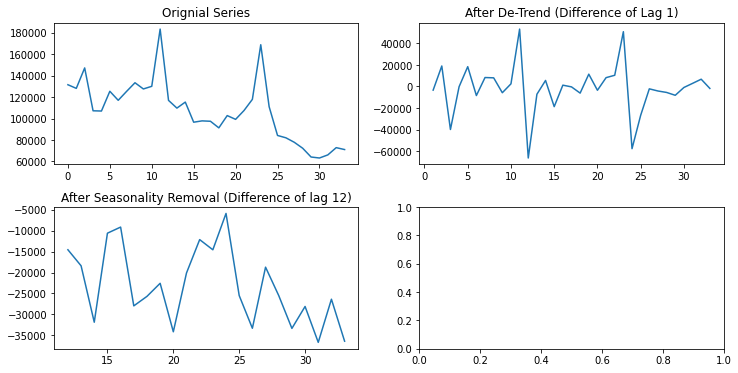

In [62]:
fig, axes = plt.subplots(2, 2, figsize = (12,6))
fig.subplots_adjust(hspace=0.3)
axes[0][0].plot(ts)
axes[0][0].set_title('Orignial Series')
axes[0][1].plot(ts.diff(periods=1))
axes[0][1].set_title('After De-Trend (Difference of Lag 1)')
axes[1][0].plot(ts.diff(periods=12))
axes[1][0].set_title('After Seasonality Removal (Difference of lag 12)')
plt.show()

A differencing of lag 1 perfectly removed the trend(so, linear trend) but strong saeasonality. The differencing of lag 12 removes the seasonality but some trend seen. Requires careful callibration.

In [63]:
# Original series
ts[-10:]

date_block_num
24    110971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     71056.0
Name: item_cnt_day, dtype: float64

In [64]:
# Differencing by lag order of 1 , once = xt - xt-1
ts.diff(1)[-10:]

date_block_num
24   -57784.0
25   -26773.0
26    -2184.0
27    -4187.0
28    -5532.0
29    -8181.0
30     -927.0
31     2892.0
32     6764.0
33    -1787.0
Name: item_cnt_day, dtype: float64

In [65]:
# Differencing by lag order of 2, once = xt - xt-2
ts.diff(2)[-10:]

date_block_num
24    -6874.0
25   -84557.0
26   -28957.0
27    -6371.0
28    -9719.0
29   -13713.0
30    -9108.0
31     1965.0
32     9656.0
33     4977.0
Name: item_cnt_day, dtype: float64

In [67]:
# Differencing order 2 - by lag order of 1 , twice = (xt - xt-1) - (xt-1 - xt-2) of original series 
# or 1st order difference new series
# OR Difference order 2
# NOT THE SAME AS .diff(2)
ts.diff(1).diff(1)[-10:]

date_block_num
24   -108694.0
25     31011.0
26     24589.0
27     -2003.0
28     -1345.0
29     -2649.0
30      7254.0
31      3819.0
32      3872.0
33     -8551.0
Name: item_cnt_day, dtype: float64

In [68]:
new_ts = ts.diff(12)

# for inverse operation simply shift the original ts by the same period and add to the differenced time series.
# Like so.
(ts.shift(12) + ts.diff(12))[-3:]

date_block_num
31    66079.0
32    72843.0
33    71056.0
Name: item_cnt_day, dtype: float64

In [70]:
# Checking the Augmented Dickey Fuller test results now, pd.diff includes NaNs - remove those before test.

# after De trend - even larger p value, and t stat falls in no critical region. The seasonality became stark, thats why ?

new_ts = ts.diff(periods=1)
print('ADF after Differencing of lag 1 to remove trend')
new_ts.dropna(inplace=True)
perf_adf(new_ts)

# after de seasonality - 12 month - Statistically significant as p value < 0.05 and t-stat in critical region.
# so reject Null, accept alt - the time series is stationary.
new_ts = ts.diff(periods=12)
new_ts.dropna(inplace=True)
print('ADF after Differencing of lag 12 to remove seasonality')
perf_adf(new_ts)

ADF after Differencing of lag 1 to remove trend


Test- Stat           -1.363622e+01
P-Value               1.686395e-25
# of Lags Used        1.000000e+01
# of Obs Used         2.200000e+01
Critical Value 1%    -3.769733e+00
Critical Value 5%    -3.005426e+00
Critical Value 10%   -2.642501e+00
dtype: float64

ADF after Differencing of lag 12 to remove seasonality


Test- Stat            -3.270101
P-Value                0.016269
# of Lags Used         0.000000
# of Obs Used         21.000000
Critical Value 1%     -3.788386
Critical Value 5%     -3.013098
Critical Value 10%    -2.646397
dtype: float64

In [45]:
# We can easily get back the original series using the inverse transform 
# for inverse operation simply shift the original ts by the same period and add to the differenced time series.
# Like so.
(ts.shift(12) + ts.diff(12))[-3:]

date_block_num
31    66079.0
32    72843.0
33    71056.0
Name: item_cnt_day, dtype: float64

### Forecasting

### Checking which model suits the time series - Using Autorcorrelation function (ACF) and the PACF
We've already differenced the time series. ARIMA models are suitable when the time series has some evidence of non- stationarity. And we need to decide the order of both the AR(p) and MA(q) models using the ACF and PACF.

In [46]:
# Do this first on a simulated process ? - Hmm, will give a bit of practise to create simulated time series'

# setting seed for reproducibility
np.random.seed(1)

# Simulating an Autoregressive - AR(1) process, so the time series x[t] is a function of itself at diff. lag h only.
# alpha is the coefficient of x[t-1] and the error is wt. Assuming all of these terms from the normal distribution.

n_samples =1000
a = 0.6

x = w = np.random.random(size = n_samples)

for t in range(n_samples):
    # alpha is absolutely neccessary here
    x[t] = a* x[t-1] + w[t]

In [47]:
plt.figure(figsize=(16,4))
plt.plot(x)
plt.show()

In [48]:
# NO TREND OR SEASONALITY

perf_adf(x)

Test- Stat           -1.359367e+01
P-Value               2.014155e-25
# of Lags Used        2.000000e+00
# of Obs Used         9.970000e+02
Critical Value 1%    -3.436926e+00
Critical Value 5%    -2.864443e+00
Critical Value 10%   -2.568316e+00
dtype: float64

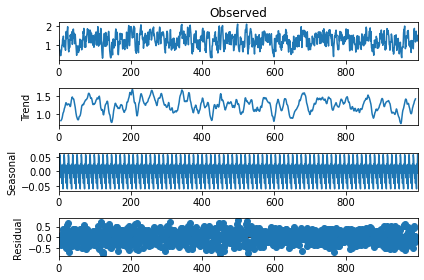

In [49]:
res = sms.tsa.seasonal_decompose(x, model='additive', period=12)
res.plot()

#### Check the Autocorrelation Plot - Using statsmodels.api.graphics.tsaplot.plot_acf(x, ax=None, lags=None, *, alpha=0.05)
Where lags is the lag for which acf is plotted, alpha is for confidence interval 1- alpha) <br>
The ACF gives the correleation between two time dependent random vars. with a lag of h. - For a time series, the autocoorrelation between xt and xt-h depends only on the lag.<br>
1. For an AR(p) process the ACF plot Tails off exponentially or in a sine wave.
2. For an MA(q) process it cuts off after lag q. 
3. For an ARMA(p,q) process, it tails off. 

In [274]:
# It Does tail off (AR) and not cut off, but we can't use this to get order of AR process.
acf = sms.graphics.tsa.plot_acf(x, lags = 12, alpha = 0.05)

#### Check the Partial Autocorrelation PLot (PACF) - 
It is the correlation between xt and xs with the linear effect of everything in the middle removed. 
1. For an AR(p) model is cuts off after lag q.
2. For an MA(q) model it tails off.
3. For an ARMA(p,q) model it tails off.

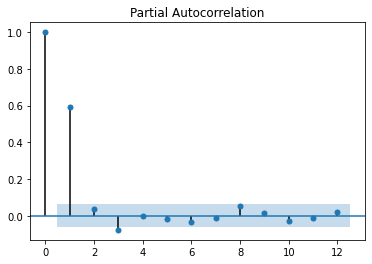

In [275]:
# Cuts off after lag 1. So, AR(1) process.
pacf = sms.graphics.tsa.plot_pacf(x, lags = 12, alpha = 0.05)

### Summary of Determining Model
|  |  |
|---|---|
|<b>ACF Shape</b>|<b>	Indicated Model</b>|
|Exponential, decaying to zero. |Autoregressive model.Use the partial autocorrelation plot to identify the order of the autoregressive model|	
|Alternating positive and negative, decaying to zero.| Autoregressive model. Use the partial autocorrelation plot to help identify the order.|	
|One or more spikes, rest are essentially zero|	Moving average model, order identified by where plot becomes zero.|	
|Decay, starting after a few lags|	Mixed autoregressive and moving average (ARMA) model.|	
|All zero or close to zero|	Data are essentially random.|	
|High values| at fixed intervals	Include seasonal autoregressive term.|	
|No decay to zero|	Series is not stationary|

#### When to log transform time-series 
Plot a graph of the data against time. If it looks like the variation increases with the level of the series, take logs. Otherwise model the original data.

## Selecting Model for Monthly Sales Data
ARMA(1,1)
Flatline predictions, look at ritvik maths workflow.

In [182]:
new_ts

date_block_num
12   -14580.0
13   -18403.0
14   -31845.0
15   -10634.0
16    -9180.0
17   -27952.0
18   -25686.0
19   -22570.0
20   -34124.0
21   -20119.0
22   -12164.0
23   -14587.0
24    -5928.0
25   -25489.0
26   -33283.0
27   -18729.0
28   -25495.0
29   -33315.0
30   -28093.0
31   -36642.0
32   -26365.0
33   -36366.0
Name: item_cnt_day, dtype: float64

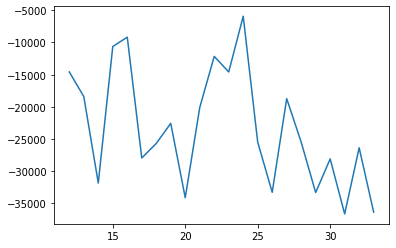

In [71]:
# Stationary time series after differencing with lag operator 12.
plt.plot(new_ts)

In [72]:
perf_adf(new_ts)

Test- Stat            -3.270101
P-Value                0.016269
# of Lags Used         0.000000
# of Obs Used         21.000000
Critical Value 1%     -3.788386
Critical Value 5%     -3.013098
Critical Value 10%    -2.646397
dtype: float64

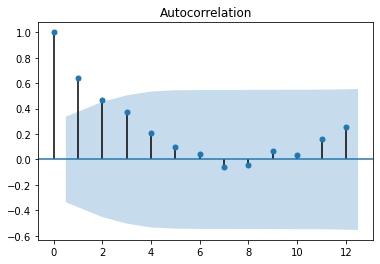

In [84]:
# MA(1) - process. ? lag doesn't cut off
acf = sms.graphics.tsa.plot_acf(ts, lags = 12, alpha = 0.05)

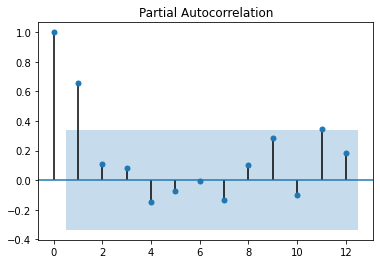

In [82]:
# AR(1) process.
pacf = sms.graphics.tsa.plot_pacf(ts, lags = 12, alpha = 0.05)

#### Fitting ARMA(1,1) model
ARMA(endog, order, exog=None, dates=None, freq=None, missing='none')<br>
1. endog - time series variable.
2. order : The (p,q) for model.
3. freq, missing has to do with a missing datetime index, should be ignored if pandas.Series with datetime.
4. .fit(method =  This is the loglikelihood to maximize
5. .fit(trend Whether to include a constant or not.  'c' includes constant. 'nc' no constant.)

In [152]:
# instantialing model - This has been deprecated
# Feeding time series with already differenced data, this is basically ARIMA
model = smt.arima_model.ARMA(ts.values, order=(1, 1))
# Fitting model 
res_model = model.fit( trend='nc', method='css-mle') # Returns a wrapper to result class

# Using the evaluation metric AIC - AIC rewards goodness of fit (as assessed by the likelihood function), 
# but it also includes a penalty that is an increasing function of the number of estimated parameters.
# Lower is better.
res_model.aic

784.1569017567957

In [153]:
# What are these parameters of the model ? - Coefficients for AR(1) and MA(1) Proceeses ? Likely
res_model.params

array([ 0.9927546 , -0.40641368])

In [154]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                -389.078
Method:                       css-mle   S.D. of innovations          21477.554
Date:                Wed, 08 Jul 2020   AIC                            784.157
Time:                        21:17:03   BIC                            788.736
Sample:                             0   HQIC                           785.718
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.9928      0.010     96.250      0.000       0.973       1.013
ma.L1.y       -0.4064      0.187     -2.170      0.030      -0.774      -0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0073           +0.0000j            1.0073            0.0000
MA.1            2.4605           +0.0000j            2.4605            0.0000
-----------------------------------------------------------------------------
"""

#### So, time series :
y<sup>^</sup>t = 0.9951y<sub>t-1</sub> - 0.731E<sub>t-1</sub>

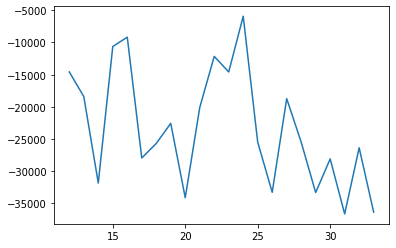

In [155]:
# Training data
plt.plot(new_ts)

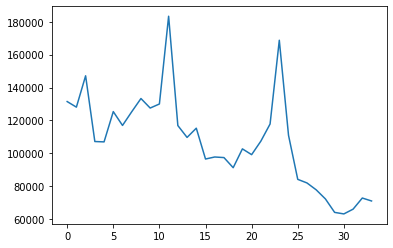

In [156]:
plt.plot(ts)

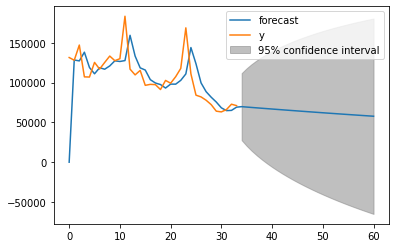

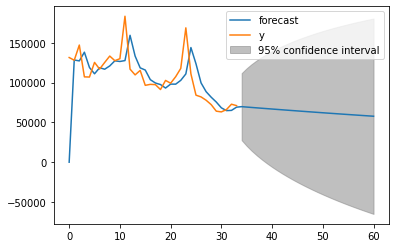

In [157]:
res_model.plot_predict(end = 60)

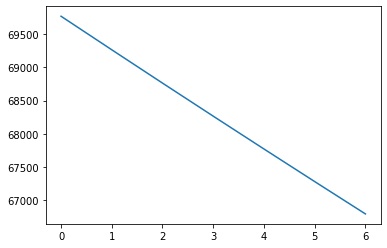

In [158]:
# Predicting using the fitted model - Not properly Tuned - Flat line predictions ? 

preds = model.predict(res_model.params, start=34, end=40)
plt.plot(preds)

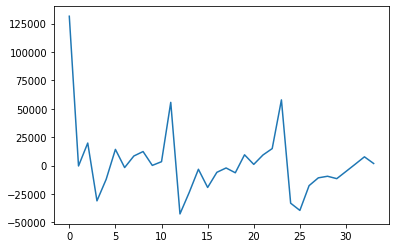

In [159]:
# Plotting Residuals - There is seasonality in residuals, is a problem
plt.plot(res_model.resid)

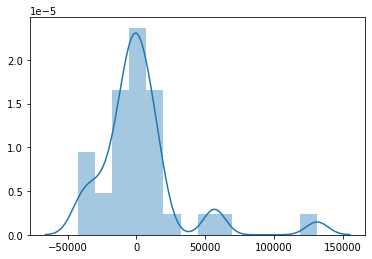

In [160]:
# Not a smooth Gaussian distribution - there are problems.
sns.distplot(res_model.resid)

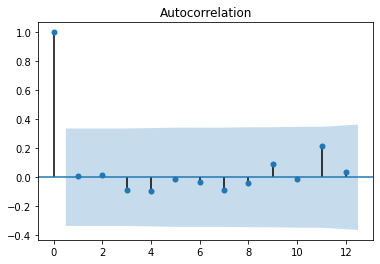

In [161]:
# Plotting acf of residuals 
acf = sms.graphics.tsa.plot_acf(res_model.resid, lags = 12, alpha = 0.05)

## Trying SARIMA
model of the form :
ARIMA(p,d,q)(P,D,Q,S)<br>
1. with SARIMAX(0,0,0)(1,1,1,12) There is a downward trend to the residuals. All coefficients significant, tends to give optimistic forecast. AIC - 483.1289169103417
2. with SARIMA (0,1,0)(1,1,1,12) - The trend in residuals is gone and replaced by volatility. Coefficeints no longer significant. Predictions are more punishing. AIC - 452.73. Don't know if this considers he lost time point due to the differencing - don't think so.

In [163]:
perf_adf(ts.diff(12).dropna())

Test- Stat            -3.270101
P-Value                0.016269
# of Lags Used         0.000000
# of Obs Used         21.000000
Critical Value 1%     -3.788386
Critical Value 5%     -3.013098
Critical Value 10%    -2.646397
dtype: float64

In [462]:
# instantialing model - This has been deprecated
model = smt.statespace.sarimax.SARIMAX(ts, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
# Fitting model 
res_model = model.fit() # Returns a wrapper to result clas
# Using the evaluation metric AIC - AIC rewards goodness of fit (as assessed by the likelihood function), 
# but it also includes a penalty that is an increasing function of the number of estimated parameters.
# Lower is better.
res_model.aic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


452.73754141768717

In [463]:
res_model.params

ar.S.L12    6.954770e-01
ma.S.L12   -9.040116e-01
sigma2      1.151745e+08
dtype: float64

In [464]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         item_cnt_day   No. Observations:                   34
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -223.369
Date:                              Thu, 09 Jul 2020   AIC                            452.738
Time:                                      00:31:07   BIC                            455.871
Sample:                                           0   HQIC                           453.418
                                               - 34                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.6955      0.606      1.147      0.251      -0.493       1.884
ma.S.L12      -0.9040      1.052     -0.859      0.390      -2.966       1.158
sigma2      1.152e+08   1.95e-08    5.9e+15      0.000    1.15e+08    1.15e+08
===================================================================================
Ljung-Box (Q):                       16.83   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.66   Prob(JB):                         0.68
Heteroskedasticity (H):               0.79   Skew:                             0.06
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.62e+31. Standard errors may be unstable.
"""

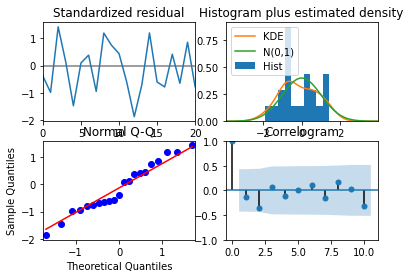

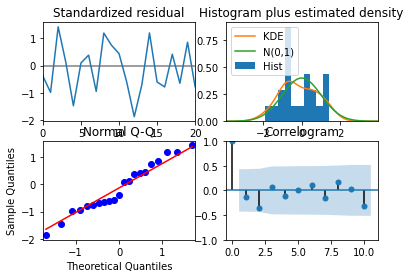

In [465]:
res_model.plot_diagnostics()

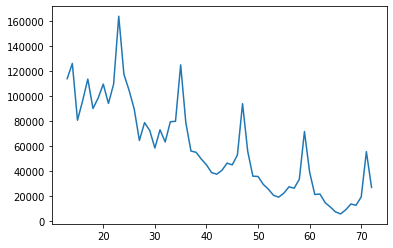

In [471]:
# plt.figure(figsize=(12,6))
plt.plot(res_model.predict(start = 13, end=72))

# Another Dataset - Monthly Temperature datatset of Armori City, predicting this temperature.

In [552]:
temp_data = pd.read_csv('monthly_temperature_aomori_city.csv')

In [553]:
# creating a date time column with existing year, month info and adding dummy day 1.
temp_data['Date'] = pd.to_datetime(temp_data[['year', 'month']].assign(day = 1))

In [270]:
#temp_data.drop(['year', 'month'], axis = 1, inplace=True)

In [554]:
temp_data.set_index('Date', inplace=True)

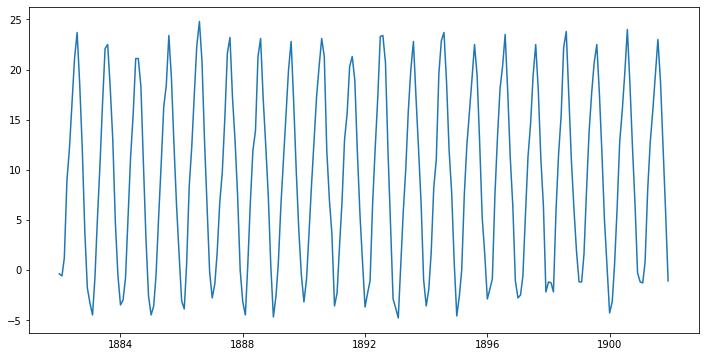

In [555]:
plt.figure(figsize=(12,6))
plt.plot(temp_data.temperature[:240])
# Just perfect seasonality(literally) and no strong trend and constant mean, variance, covariance ?

#### Grouping by Year

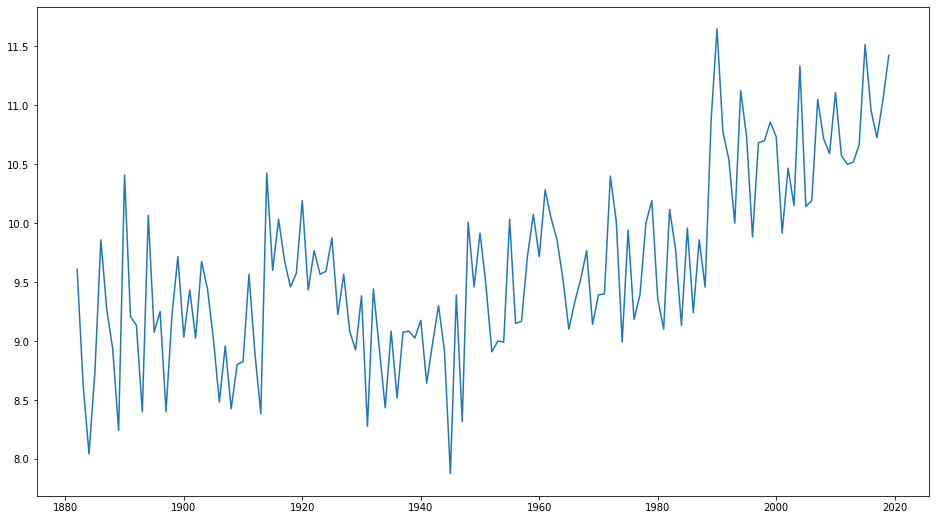

In [556]:
plt.plot(temp_data.groupby(['year'])['temperature'].mean())

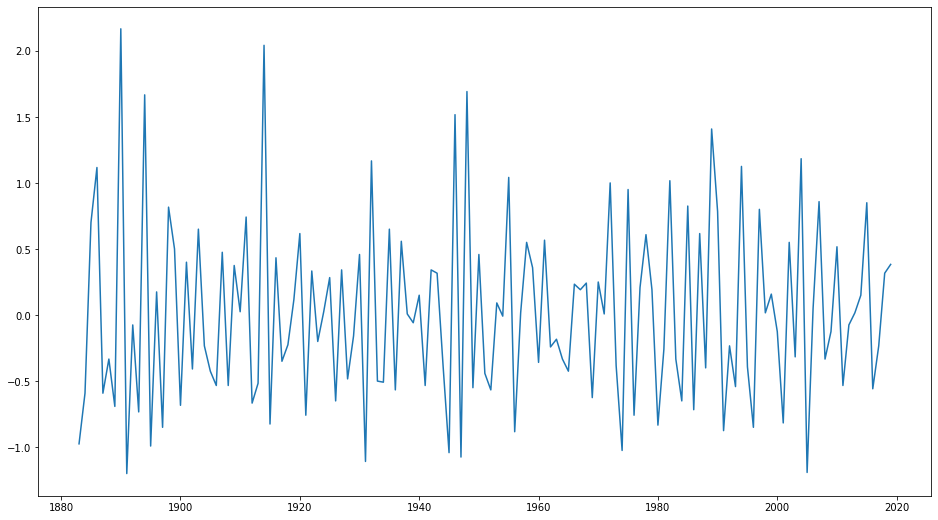

In [557]:
plt.plot(temp_data.groupby(['year'])['temperature'].mean().diff(1))

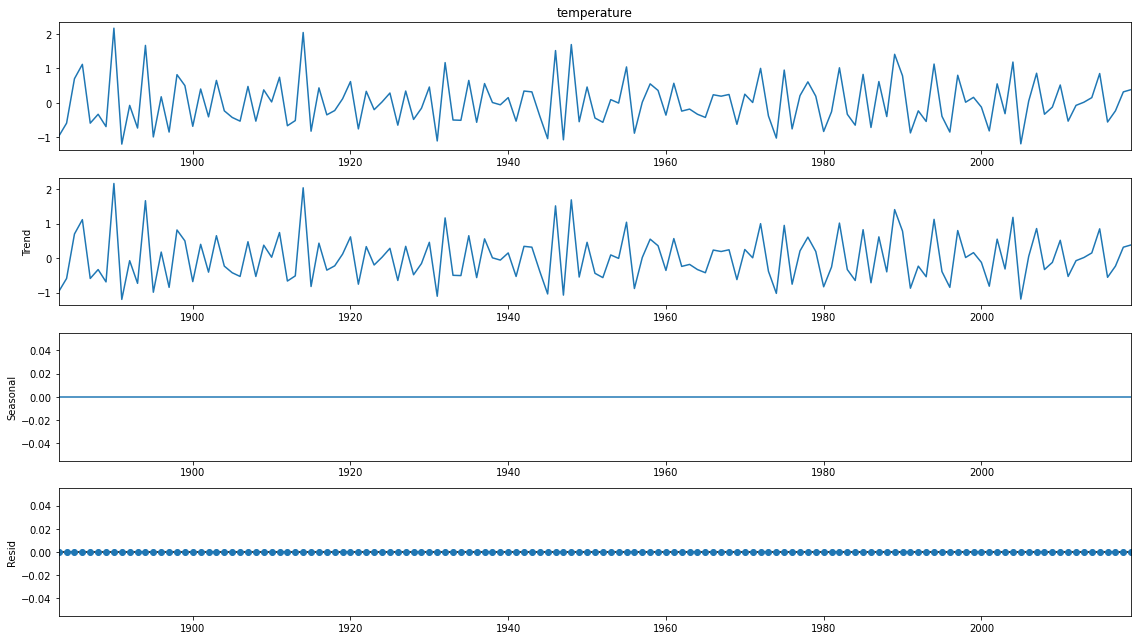

In [558]:
# sms - statsmodels api - has tsa package in it, statsmodels.tsa is another pakage.
decomp = sms.tsa.seasonal_decompose(temp_data.groupby(['year'])['temperature'].mean().diff(1).dropna(),
                                    model='additive', period = 1)
plt.rcParams['figure.figsize'] = [16,9]
fig = decomp.plot()

In [559]:
perf_adf(temp_data.groupby(['year'])['temperature'].mean())

Test- Stat             -0.788338
P-Value                 0.822524
# of Lags Used          4.000000
# of Obs Used         133.000000
Critical Value 1%      -3.480500
Critical Value 5%      -2.883528
Critical Value 10%     -2.578496
dtype: float64

In [560]:
perf_adf(temp_data.groupby(['year'])['temperature'].mean().diff(1).dropna())

Test- Stat           -1.035816e+01
P-Value               2.435743e-18
# of Lags Used        3.000000e+00
# of Obs Used         1.330000e+02
Critical Value 1%    -3.480500e+00
Critical Value 5%    -2.883528e+00
Critical Value 10%   -2.578496e+00
dtype: float64

## Back to ungrouped data

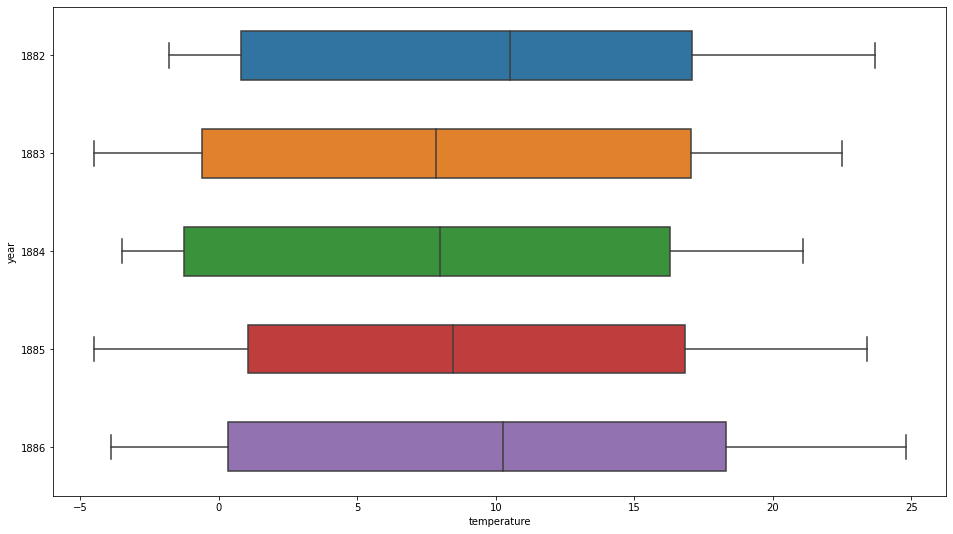

In [561]:
# Boxplot of temperature for first 5 years 

sns.boxplot(y = 'year', x = 'temperature', data = temp_data[:60], orient = 'h', width=.5)

In [300]:
# Decomposition, since seasonal variation is similar over time - use additive model.

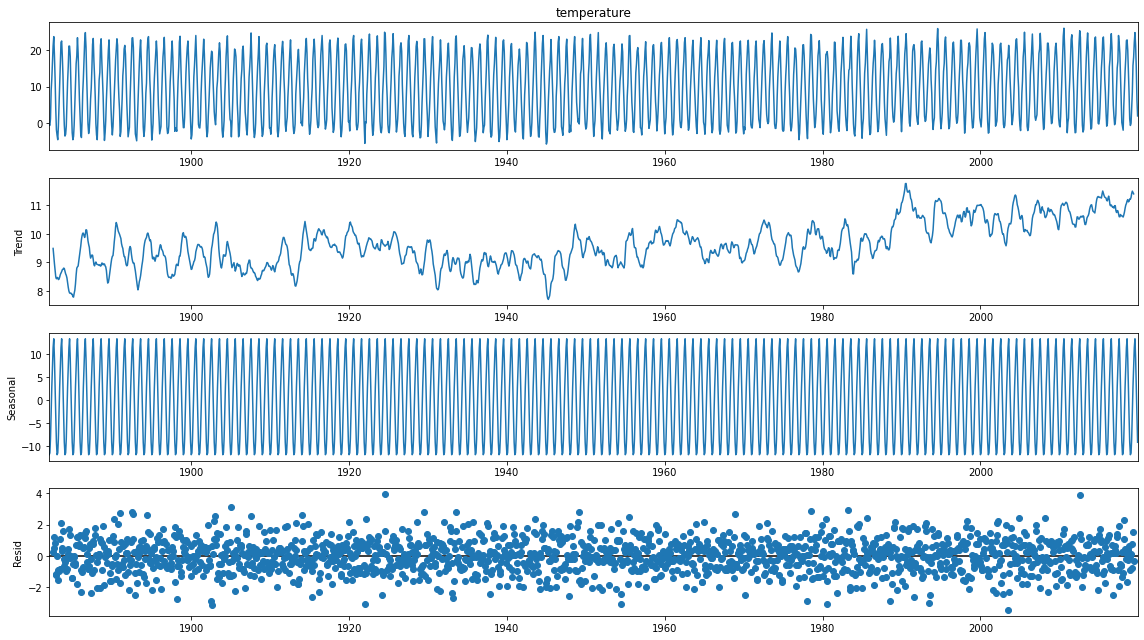

In [562]:
# sms - statsmodels api - has tsa package in it, statsmodels.tsa is another pakage.
decomp = sms.tsa.seasonal_decompose(temp_data.temperature, model='additive')
plt.rcParams['figure.figsize'] = [16,9]
fig = decomp.plot()

In [850]:
# Check for stationarity - Augmented dickey fuller test 
%time perf_adf(temp_data.temperature)
# Stationary Series

Test- Stat              -2.936397
P-Value                  0.041276
# of Lags Used          23.000000
# of Obs Used         1632.000000
Critical Value 1%       -3.434363
Critical Value 5%       -2.863313
Critical Value 10%      -2.567714
dtype: float64

CPU times: user 137 ms, sys: 34.2 ms, total: 171 ms
Wall time: 109 ms


[]

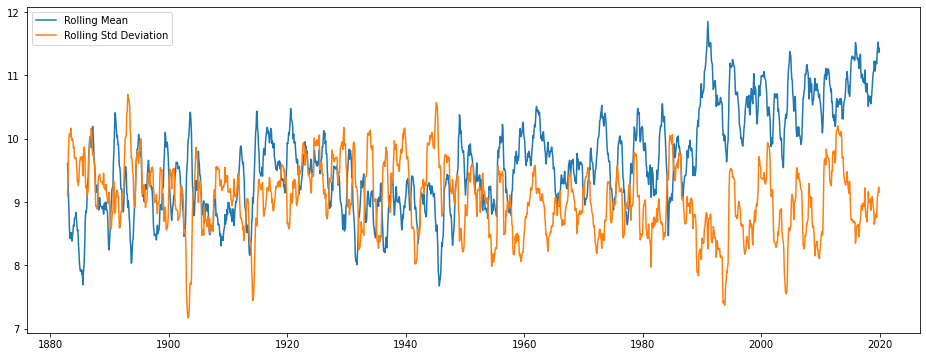

In [564]:
# Checking the rolling mean and standard deviation. Look at that sharp increase after the 80's
# The rolling standard deviation has also become more volatile. Colder winters, hotter summers :O
plt.figure(figsize=(16,6))
plt.plot(temp_data.temperature.rolling(window=12).mean(),label='Rolling Mean')
plt.plot(temp_data.temperature.rolling(window=12).std(),label='Rolling Std Deviation')
plt.legend()
plt.plot()

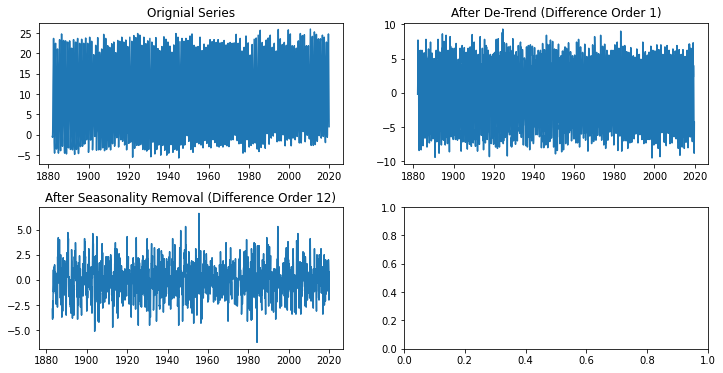

In [742]:
fig, axes = plt.subplots(2, 2, figsize = (12,6))
fig.subplots_adjust(hspace=0.3)
axes[0][0].plot(temp_data.temperature)
axes[0][0].set_title('Orignial Series')
axes[0][1].plot(temp_data.temperature.diff(periods=1))
axes[0][1].set_title('After De-Trend (Difference Order 1)')
axes[1][0].plot(temp_data.temperature.diff(periods=12))
axes[1][0].set_title('After Seasonality Removal (Difference Order 12)')
plt.show()

### Checking which model to fit using ACF and PACF
ACF decays very slowly, still an AR process ?

In [849]:
# Diferencing by 1 doesn't really help. Differencing by 12 helps, AR seems more likely now.
%time acf = sms.graphics.tsa.plot_acf(temp_data.temperature, lags = 400, alpha = 0.05)

CPU times: user 33.6 ms, sys: 4.25 ms, total: 37.8 ms
Wall time: 36.6 ms


In [676]:
pacf = sms.graphics.tsa.plot_pacf(temp_data.temperature, lags = 100, alpha = 0.05)
# Based on the plot, try 1, 2, 3, 4, 5, 11, 12 as lags ?

#### Fitting the model

In [ ]:
# Strongest lag at 2 so try AR(2) and MA(4 - why ?????) process ARMA(2, 4) with constant 
# ARIMA 4,1,6 Also provides similar results. - Slightly Better RSME - 1.35 vs 1.42

In [851]:
# instantialing model - This has been deprecated
model = smt.arima_model.ARIMA(temp_data.temperature, order=(2,0, 4))
# Fitting model 
%prun res_model = model.fit( trend='c', method='css-mle') # Returns a wrapper to result clas
# Using the evaluation metric AIC - AIC rewards goodness of fit (as assessed by the likelihood function), 
# but it also includes a penalty that is an increasing function of the number of estimated parameters.
# Lower is better.
res_model.aic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


5844.802455565575

In [812]:
# What are these parameters of the model ? - Coefficients for AR(1) and MA(1) Proceeses ? Likely
res_model.params

const                9.664654
ar.L1.temperature    1.732019
ar.L2.temperature   -1.000000
ma.L1.temperature   -1.252123
ma.L2.temperature    0.237865
ma.L3.temperature    0.370211
ma.L4.temperature    0.045676
dtype: float64

In [845]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            temperature   No. Observations:                 1656
Model:                     ARMA(2, 4)   Log Likelihood               -2914.401
Method:                       css-mle   S.D. of innovations              1.392
Date:                Sat, 04 Jul 2020   AIC                           5844.802
Time:                        23:26:00   BIC                           5888.100
Sample:                    01-01-1882   HQIC                          5860.852
                         - 12-01-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.6647      0.000    2.3e+04      0.000       9.664       9.665
ar.L1.temperature     1.7320   7.43e-05   2.33e+04      0.000       1.732       1.732
ar.L2.temperature    -1.0000        nan        nan        nan         nan         nan
ma.L1.temperature    -1.2521      0.026    -48.684      0.000      -1.303      -1.202
ma.L2.temperature     0.2379      0.036      6.550      0.000       0.167       0.309
ma.L3.temperature     0.3702      0.030     12.238      0.000       0.311       0.430
ma.L4.temperature     0.0457      0.018      2.518      0.012       0.010       0.081
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8660           -0.5000j            1.0000           -0.0833
AR.2            0.8660           +0.5000j            1.0000            0.0833
MA.1            0.8747           -0.5067j            1.0109           -0.0836
MA.2            0.8747           +0.5067j            1.0109            0.0836
MA.3           -3.2384           -0.0000j            3.2384           -0.5000
MA.4           -6.6162           -0.0000j            6.6162           -0.5000
-----------------------------------------------------------------------------
"""

#### Residual Analysis

In [814]:
res_model.resid.plot()

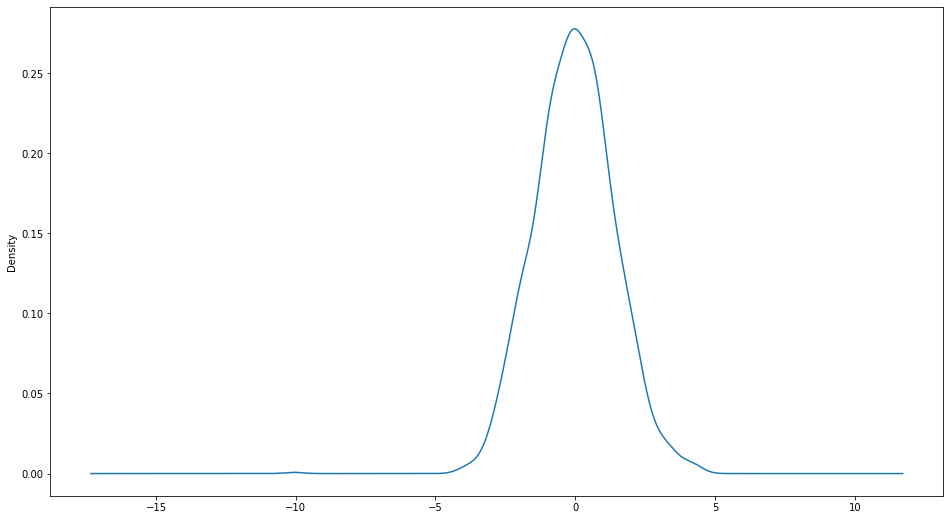

In [815]:
res_model.resid.plot(kind='kde')

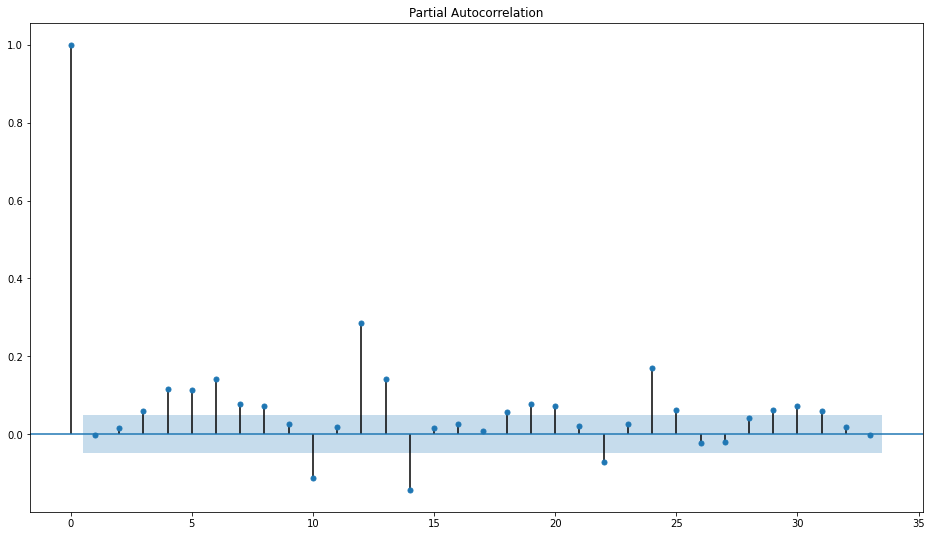

In [816]:
pacf = sms.graphics.tsa.plot_pacf(res_model.resid)

#### Predictions 

In [817]:
plot = res_model.plot_predict(1600, 1700)

In [818]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [819]:
rmse =sqrt(mean_squared_error(temp_data.temperature, res_model.predict()))
print(rmse)

1.4202901450697567


#### Forecast

In [820]:
n=36
forecast,err,ci = res_model.forecast(steps=n,alpha=0.05)
df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='1/1/2020', periods=n, freq='MS'))

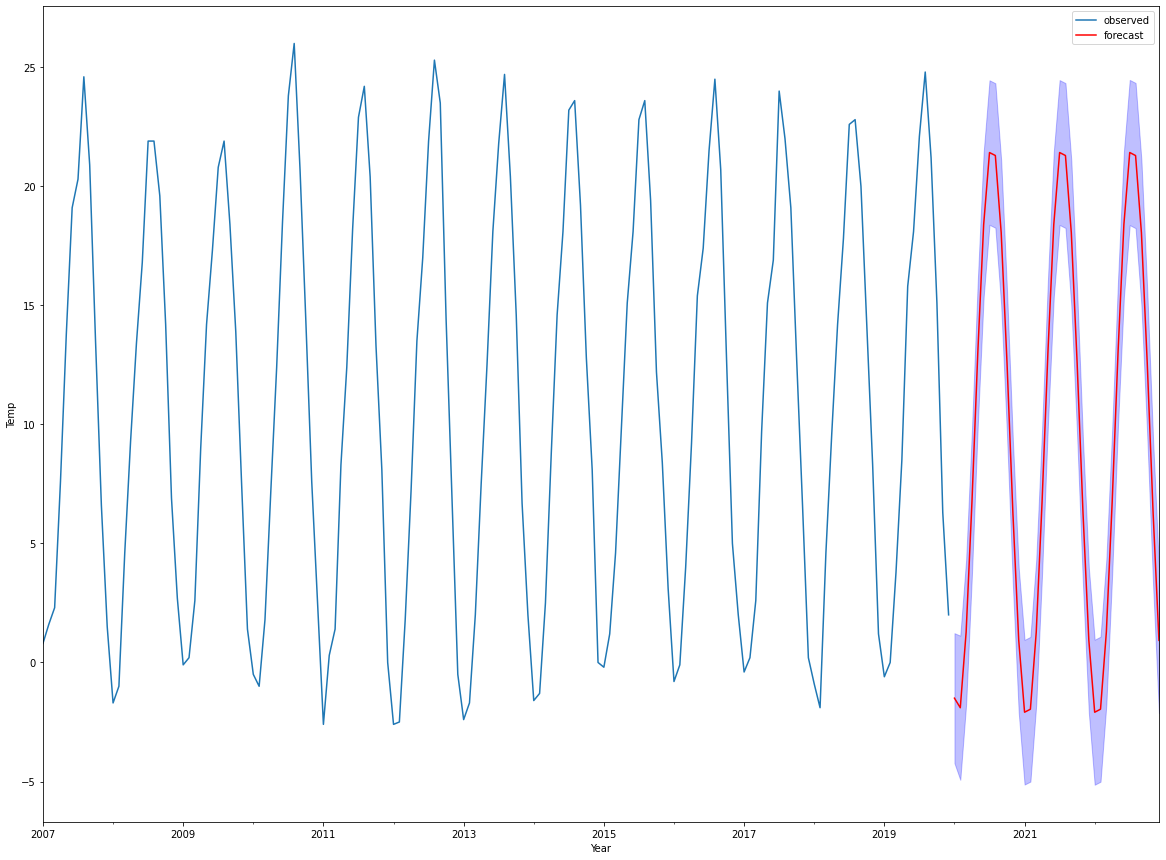

In [821]:
ax = temp_data[1500:].temperature.plot(label='observed', figsize=(20, 15))
df_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='b', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Temp')

plt.legend()
plt.show()
